In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time

import modutils

data_dir = '../DataSets/Churn/'

In [51]:
fname = data_dir + 'user_logs.csv'
batch_size = 1000000 #1mln
num_steps = 600 #more than needed
res = None

with open(fname, 'r') as f:
    f.readline()
    for step in range(num_steps):
        t0 = time.perf_counter()
        lines = [f.readline().replace('\n','').split(',') for i in range(batch_size)]
        if lines is None or len(lines) == 0:
            print('\nStopped at {0} steps'.format(num_steps))
            break
        flines = [x for x in lines if int(x[1])>20170200]
        if len(flines)==0:
            continue
        tmp = pd.DataFrame(data=flines,
                           columns=['msno', 'dt', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'totsec'])
        t1 = time.perf_counter()
        if res is None:
            res = tmp
        else:
            res = pd.concat([res,tmp])
        print('Step {0}: Read {1} entries (total: {2}) in {3:.2f} seconds'.format(step, len(tmp), len(res), t1-t0), end='\r')

KeyboardInterrupt: 

In [55]:
ress = res.sort_values(by=['msno','dt'])

In [57]:
ress.to_csv(data_dir + 'user_log1702_part.csv')

In [2]:
fname_log = data_dir + 'user_log1702_part.csv'
fname_trgt = data_dir + 'train.csv'

src_log = pd.read_csv(fname_log)
src_trgt = pd.read_csv(fname_trgt)

In [3]:
src = pd.merge(left=src_log, right=src_trgt, how='left', on='msno')

In [15]:
src['num_tot'] = src.num_25 + src.num_50 + src.num_75 + src.num_985 + src.num_100
src['pct_low'] = src.num_25 / src.num_tot
src['pct_high'] = (src.num_50 + src.num_75 + src.num_985) / src.num_tot
src['pct_full'] = src.num_100 / src.num_tot
src['pct_unq'] = src.num_unq / src.num_tot
src['avg_sec'] = src.totsec / src.num_tot
src['avg_sec100'] = src.totsec / np.maximum(1, src.num_100)

In [122]:
src['lgt_low'] = np.log(np.maximum(0.001, src.pct_low) / (1 - np.minimum(0.999, src.pct_low)))
src['f0_low'] = 1.0*(src.pct_low <= 0.001)
src['f1_low'] = 1.0*(src.pct_low >= 0.999)

src['lgt_high'] = np.log(np.maximum(0.001, src.pct_high) / (1 - np.minimum(0.999, src.pct_high)))
src['f0_high'] = 1.0*(src.pct_high <= 0.001)
src['f1_high'] = 1.0*(src.pct_high >= 0.999)

src['lgt_full'] = np.log(np.maximum(0.001, src.pct_full) / (1 - np.minimum(0.999, src.pct_full)))
src['f0_full'] = 1.0*(src.pct_full <= 0.001)
src['f1_full'] = 1.0*(src.pct_full >= 0.999)

src['lgt_unq'] = np.log(np.maximum(0.001, src.pct_unq) / (1 - np.minimum(0.999, src.pct_unq)))
src['f0_unq'] = 1.0*(src.pct_unq <= 0.001)
src['f1_unq'] = 1.0*(src.pct_unq >= 0.999)

src['ln_num_tot'] = np.log(src.num_tot)
src['ln_num_100'] = np.log(1 + src.num_100)

src['ln_tot_sec'] = np.log(src.totsec)
src['mx_avg_sec'] = np.minimum(360, src.avg_sec)

pct_modifiers = ['f0', 'f1', 'lgt'] 
pct_sources = ['low', 'high', 'full', 'unq']
other_features = ['ln_num_tot', 'ln_tot_sec', 'mx_avg_sec']

features = other_features + [x+'_'+y for x in pct_modifiers for y in pct_sources]
target = 'is_churn'

In [172]:
#src01 = src[(src.dt==20170201)&(~np.isnan(src.is_churn))]
src01 = src[(~np.isnan(src.is_churn))]

In [279]:
devX = np.array(src01[features])
devY = np.array(src01[target])
(trainX, trainY), (testX, testY) = modutils.splitSample((devX, devY), pcts=[0.7, 0.3])

In [282]:
eval_model(m_logreg01, testX, testY)

0.04456768112481635

In [278]:
import sklearn
import sklearn.linear_model, sklearn.ensemble, sklearn.metrics

def eval_model(m, tX, tY):
    tP = m.predict_proba(tX)[:,1]
    tL = np.log(tP / (1-tP))
    return sklearn.metrics.roc_auc_score(tY, tL)*2-1

In [174]:
t0 = time.perf_counter()
m_logreg01 = sklearn.linear_model.LogisticRegression(penalty='l1').fit(trainX, trainY)
t1 = time.perf_counter()
g = eval_model(m_logreg01, trainX, trainY)
print('Trained in {0:.2f} seconds, gini = {1:.3f}'.format(t1-t0,g))

Trained in 82.47 seconds, gini = 0.047


In [165]:
t0 = time.perf_counter()
m_gboost01 = sklearn.ensemble.GradientBoostingClassifier().fit(trainX, trainY)
t1 = time.perf_counter()
g = eval_model(m_gboost01, trainX, trainY)
print('Trained in {0:.2f} seconds, gini = {1:.3f}'.format(t1-t0,g))

Trained in 11.15 seconds, gini = 0.054


In [169]:
t0 = time.perf_counter()
m_gboost02 = sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=100, min_samples_split=100, max_depth=5, n_estimators=200).fit(trainX, trainY)
t1 = time.perf_counter()
g = eval_model(m_gboost02, trainX, trainY)
print('Trained in {0:.2f} seconds, gini = {1:.3f}'.format(t1-t0,g))

Trained in 36.81 seconds, gini = 0.054


In [175]:
src_p = m_logreg01.predict_proba(np.array(src[features]))[:,1]

In [178]:
src['f_lgt'] = np.log(src_p / (1-src_p))

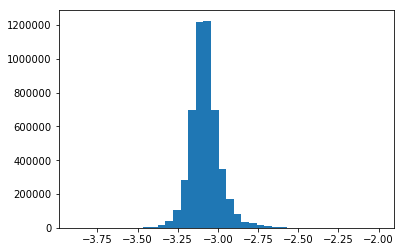

In [180]:
plt.hist(src[src.f_lgt <-2].f_lgt, bins=40)
plt.show()

In [181]:
tmp = src.copy()

In [182]:
tmp['g'] = np.floor(tmp.f_lgt*10)/10
tmp.groupby('g')['is_churn'].mean()

In [252]:
srcg = src.groupby('msno').agg({'dt':['min','max','count'], 'num_tot':['min','max','mean'], 'f_lgt':['min','max','mean'],'is_churn':'mean'})

In [253]:
srcg.columns = ['_'.join(x) for x in srcg.columns.ravel()]
srcg = srcg.rename(columns={'is_churn_mean':'is_churn'})
srcg

,dt_min,dt_max,dt_count,num_tot_min,num_tot_max,num_tot_mean,f_lgt_min,f_lgt_max,f_lgt_mean,is_churn
msno,,,,,,,,,,
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,20170201,20170204,3,6,33,20.666667,-3.030505,-2.990048,-3.005285,0.0
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,20170201,20170211,11,5,50,19.272727,-3.228556,-3.029553,-3.104501,0.0
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,20170203,20170219,16,1,65,21.000000,-3.203813,-2.746790,-3.037678,0.0
++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,20170201,20170205,5,28,54,38.400000,-3.143193,-2.982562,-3.071827,0.0
++0d7elOGPXFeAuaDppOupFQa5ihSNTzHMNibE80qhI=,20170213,20170215,3,9,57,36.666667,-3.156218,-2.880290,-3.031202,NaN
++37uKwAXaoPQVc2Qf0z5mYt/XaT/pGRSE23QyCX7kM=,20170203,20170206,4,92,370,190.750000,-3.210212,-3.096206,-3.145230,NaN
++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=,20170202,20170203,2,3,20,11.500000,-2.926947,-2.903407,-2.915177,0.0
++3FD0IDUFeGFJBskYJYbJFJOxw/pduGN5BxfKFQvC4=,20170215,20170215,1,3,3,3.000000,-2.980983,-2.980983,-2.980983,NaN
++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,20170227,20170227,1,62,62,62.000000,-2.993316,-2.993316,-2.993316,0.0


In [300]:
srcg['dt_diff'] = srcg.dt_max - srcg.dt_min
srcg['dt_killer'] = 20170228 - srcg.dt_max
srcg['dt_avg'] = srcg.dt_diff / srcg.dt_count
srcg['ln_num_tot_diff'] = np.log(srcg.num_tot_max / srcg.num_tot_min)
srcg['ln_num_tot_mean'] = np.log(srcg.num_tot_mean)

gfeatures = ['dt_diff', 'dt_avg', 'dt_count', 'ln_num_tot_diff', 'ln_num_tot_mean', 'f_lgt_min', 'f_lgt_max', 'f_lgt_mean', 'dt_killer']
gtarget = 'is_churn'

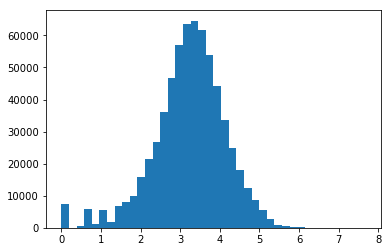

In [268]:
plt.hist(srcg.ln_num_tot_mean, bins=40)
plt.show()

In [269]:
tmpg = srcg.copy()
tmpg['g'] = np.floor(tmpg.ln_num_tot_mean)
tmpg.groupby('g')['is_churn'].mean()

g
0.0    0.118693
1.0    0.071225
2.0    0.052244
3.0    0.046725
4.0    0.047211
5.0    0.042976
6.0    0.015000
7.0    0.000000
Name: is_churn, dtype: float64

In [303]:
srcgt = srcg[~np.isnan(srcg[gtarget])]
devX = np.array(srcgt[gfeatures])
devY = np.array(srcgt[gtarget])
(trainX, trainY), (testX, testY) = modutils.splitSample((devX, devY), pcts=[0.7, 0.3])

In [304]:
t0 = time.perf_counter()
mg_logreg01 = sklearn.linear_model.LogisticRegression(penalty='l1').fit(trainX, trainY)
t1 = time.perf_counter()
g = eval_model(mg_logreg01, testX, testY)
print('Trained in {0:.2f} seconds, gini = {1:.3f}'.format(t1-t0,g))

Trained in 19.76 seconds, gini = 0.257


In [305]:
t0 = time.perf_counter()
mg_gboost01 = sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=1000, min_samples_split=1000, max_depth=4).fit(trainX, trainY)
t1 = time.perf_counter()
g = eval_model(mg_gboost01, testX, testY)
print('Trained in {0:.2f} seconds, gini = {1:.3f}'.format(t1-t0,g))

Trained in 89.29 seconds, gini = 0.305


In [306]:
mg_gboost01.feature_importances_

array([ 0.04993829,  0.06094261,  0.06436131,  0.12060242,  0.13217741,
        0.09775135,  0.11522653,  0.10266978,  0.2563303 ])

In [302]:
gfeatures

['dt_diff',
 'dt_avg',
 'dt_count',
 'ln_num_tot_diff',
 'ln_num_tot_mean',
 'f_lgt_min',
 'f_lgt_max',
 'f_lgt_mean',
 'dt_killer']

In [308]:
srcg_p = mg_gboost01.predict_proba(srcg[gfeatures])[:,1]
srcg['fin_p'] = srcg_p
srcg['fin_lgt'] = np.log(srcg_p / (1-srcg_p))

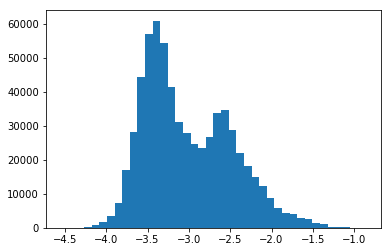

In [310]:
plt.hist(srcg.fin_lgt, bins=40)
plt.show()